## Student Name: Elsa Anza Martín

## Student ID: 21272808

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


!pip install scikit_optimize #added to solve the 'ModuleNotFoundError'

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

     |████████████████████████████████| 100 kB 3.4 MB/s 


In [3]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [4]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [5]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_errors = 1- train_scores
    test_errors = 1-test_scores
    
    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")

    
    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [7]:
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

## Task 1

In [10]:
data = np.genfromtxt("dataset_1_train.csv", delimiter=',')
data[:5]

array([[ 0.91338532, -0.13107061,  1.        ],
       [-1.39389488, -1.37378992,  0.        ],
       [-0.37956815,  1.40482855,  0.        ],
       [ 1.52572205, -1.71337933,  1.        ],
       [ 1.44418058, -0.62254835,  1.        ]])

In [11]:
X = data[:,0:2] #loading examples
y = data[:,2] #loading labels 

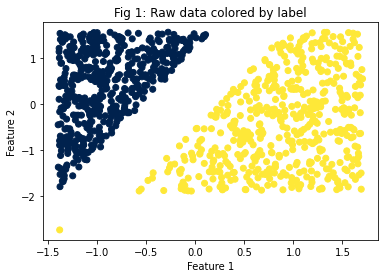

In [219]:
plt.scatter(X[:,0],X[:,1], c=y, cmap='cividis')
plt.title("Fig 1: Raw data colored by label")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [221]:
#adapted version 
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=0.5) #adapted ratio
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

### Plot for intermediate **C=1**

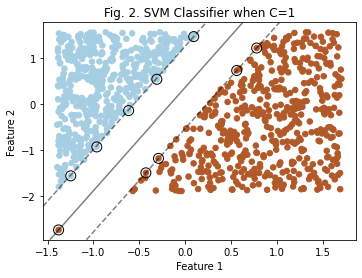

In [222]:
clf = svm.SVC(C=1, kernel='linear')
clf.fit(X, y)

plt.title("Fig. 2. SVM Classifier when C=1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X, y, clf)


### Plot for a smaller **C=0.01**

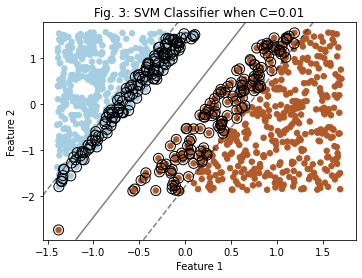

In [15]:
clf = svm.SVC(C=0.01, kernel='linear')
clf.fit(X, y)
plt.title("Fig. 3: SVM Classifier when C=0.01")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X, y, clf)

### Plot for a larger **C=10**

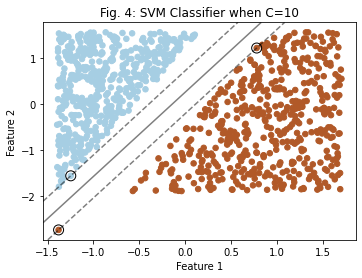

In [234]:
clf = svm.SVC(C=10, kernel='linear')
clf.fit(X, y)
plt.title("Fig. 4: SVM Classifier when C=10")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X, y, clf)

## Reflection

SVM are an approach to classification which bring in the idea of margins, which we'll see contribute robustness to decsision boundaries as we know them from other techniques like Linear Regression.

These new decision boundaries run through the space separating data clouds between a margins. This margins act as an unit of safety that provides robustness against outliers.

SVM prefer wider margins, which effectevly reduce the number of dichotomies, reducing VC dimension and thus model complexity. This means better generalisation can be achieved in comparison to other models like the linear ones previously explored.

In the three figures shown in task 1 we can visualise the decision boundaries and margins obtained when SVM classification is performed in  dataset 1, which consists of two clouds of data belonging to two classes which appears clearly separated by a wide corridor.

The dataset used in Task 1 is linearly separable, but decision boundaries are not clear. The exception is one single outlier located in the bottom left corner of the image. Because real data is noisy and outliers are a common issue in classification problems, this dataset is relevant for understanding the how tuning parameters can improve robustness of the model, which struggles to generalise when data is noisy. 

The existence of this outlier will cause the model to act very differently for different values of C:

* In figure 2, for an intermediate value of C (C=1), margin is wide the outlier is the only datapoint allowed into the margins created by the support vectors. This means our margin is a soft one. It can be seen that the Decision Boundary lies comfortably between the margins and is equally distant to both classes’ dataclouds.

* In figure 3, value of C is much lower, C=0.01. It is observed that this causes a larger number of examples to be allowed into the margin, making the margin wider but causing the decision boundary to be placed closer to the rightmost datacloud (corresponding to class 1, in brown), which might lead to bad generalisation of the model.

* In figure 4, value of C is higher (C=10). Here, no examples are allowed into the margin. This causes the outlier to impact the final decision boundary very significantly, tilting its slope considerably in comparison to the previous two graphs. The margin created in this example is hard, because it allows no examples into it, and the decision boundary is not sitting at an equal distance to both classes along its extension. This might cause bad generalisation.


Hard Constraints (not allowing any data in the margins) cause narrower margins. Because wider margines reduce dichotomies thus improving generalisation, this constraints might generalise worse. This means hard constraints are generaly something that should be avoided. The type of regularisation used in SVM aims to create soft margins for the model to generalise better.

In conclusion, the first case —which uses C=1— should be preffered, as it’s the one with the wider margin whose decision boundary stands more equally between both dataclouds on average, this is, decision boundary isn’t excesivelly close to one class than to another.

It can also be concluded that C does in fact affect the width of the margins: lower C, wider margin. Bigger C, more narrow margins. 

Finally, the most relevant conclusion is that C does benefit generalisation, as its capable of reducing complexity. Wider margins will reduce the number of dichotomies, reducing VC dimension and causing the model to generalise better. 

Note: Tried using Linear SVC, but got the error:
'LinearSVC' object has no attribute 'support*_vectors_*, so used regular SCV instead.

# Task 2

In [17]:
data2 = np.genfromtxt("dataset_2_train.csv", delimiter=',')
data2[:5]

array([[ 0.48976318, -1.31905896,  1.        ],
       [ 1.21809108,  0.02704083,  1.        ],
       [-0.75668985, -0.83401863,  1.        ],
       [-0.22576289,  0.50061889,  0.        ],
       [-1.46537112, -0.93270757,  1.        ]])

In [18]:
data3 = np.genfromtxt("dataset_3_train.csv", delimiter=',')
data3[:5]

array([[ 1.36576274, -0.85296845,  0.        ],
       [ 1.53302475,  0.93982811,  0.        ],
       [-0.37723541, -0.56832803,  1.        ],
       [ 1.13248782, -0.33936347,  0.        ],
       [ 1.28209194, -0.36677919,  0.        ]])

In [19]:
X2_train = data2[:,0:2] #loading examples for dataset 2
y2_train = data2[:,2] #loading labels 
X3_train = data3[:,0:2] #loading examples for dataset 3
y3_train = data3[:,2] #loading labels 

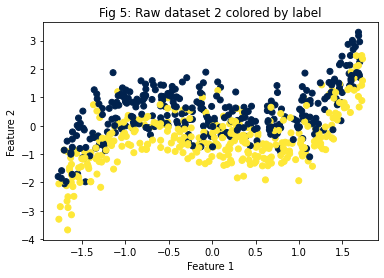

In [20]:
plt.scatter(X2_train[:,0],X2_train[:,1], c=y2_train, cmap='cividis')
plt.title("Fig 5: Raw dataset 2 colored by label")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

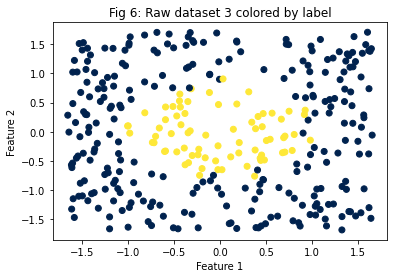

In [21]:
plt.scatter(X3_train[:,0],X3_train[:,1], c=y3_train, cmap='cividis')
plt.title("Fig 6: Raw dataset 3 colored by label")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### **Exploration of performance of SVM Classifier on Dataset 2**

In [22]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [236]:
#adapted version 
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=0.25)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='r', levels=[-1, 0, 1], alpha=1, #db in red, higher alpha
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, #sv in  lower alpha
               linewidth=1, alpha=0.4, facecolors='none', edgecolors='k')

#### **'LINEAR' kernel** 
Didn't achieve significant improvement on performance with other values of C and therefore its exploration is not recorded

MEAN ACCURACY: 0.7298507462686568


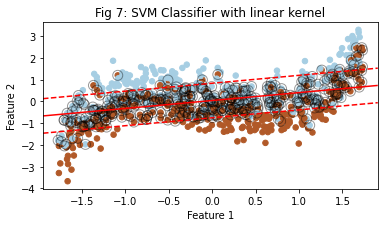

In [251]:
k= kernel_list[0]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X2_train, y2_train)
plt.title("Fig 7: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)

a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

In [55]:
clf.score(X2_train, y2_train)

0.7298507462686568

#### **Variation of C using 'POLY' kernel** 

MEAN ACCURACY: 0.6761194029850747


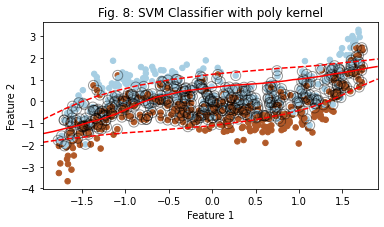

In [238]:
k= kernel_list[1]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X2_train, y2_train)
plt.title("Fig. 8: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.6761194029850747


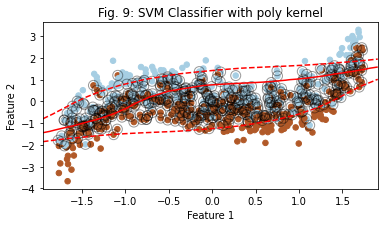

In [239]:
k= kernel_list[1]
clf = svm.SVC(kernel=k, C=0.1)
clf.fit(X2_train, y2_train)
plt.title("Fig. 9: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.6791044776119403


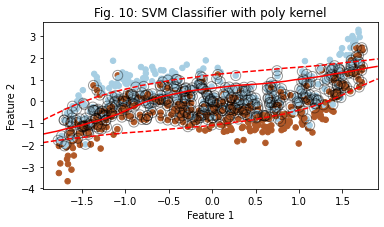

In [240]:
k= kernel_list[1]
clf = svm.SVC(kernel=k, C=5)
clf.fit(X2_train, y2_train)
plt.title("Fig. 10: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

#### **Variation of C using 'RBF' kernel** 

MEAN ACCURACY: 0.7731343283582089


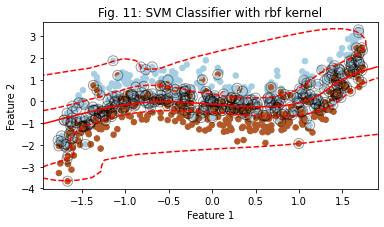

In [242]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X2_train, y2_train)
plt.title("Fig. 11: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.7298507462686568


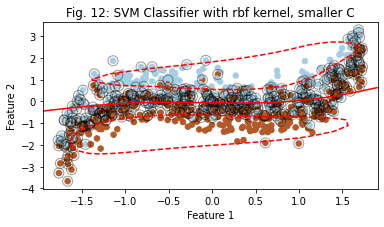

In [243]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=0.1)
clf.fit(X2_train, y2_train)
plt.title("Fig. 12: SVM Classifier with %s kernel, smaller C" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.7791044776119403


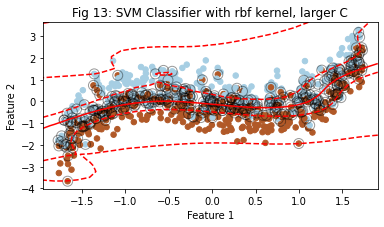

In [244]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=3)
clf.fit(X2_train, y2_train)
plt.title("Fig 13: SVM Classifier with %s kernel, larger C" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

#### **'SIGMOID' kernel** 
Didn't achieve significant performance with any value of C and therefore its exploration is not recorded

MEAN ACCURACY: 0.6447761194029851


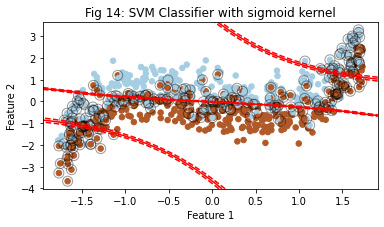

In [245]:
k= kernel_list[3]
clf = svm.SVC(kernel=k)
clf.fit(X2_train, y2_train)
plt.title("Fig 14: SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_train, y2_train, clf)
a = clf.score(X2_train, y2_train)
print("MEAN ACCURACY:", a)

### **Exploration of performance of SVM Classifier on Dataset 3**

In [32]:
#adapted version 
def plot_margin3(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='r', levels=[-1, 0, 1], alpha=1,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, alpha=0.4, facecolors='none', edgecolors='k')

#### **'LINEAR' kernel** 

MEAN ACCURACY: 0.7791044776119403


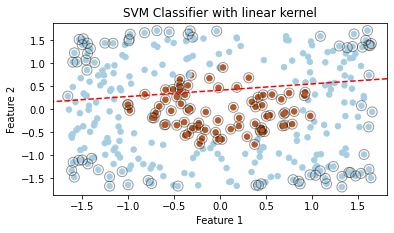

In [76]:
k= kernel_list[0]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

#### **Variation of C using 'POLY' kernel** 

MEAN ACCURACY: 0.7791044776119403


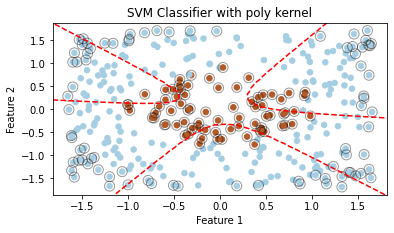

In [77]:
k= kernel_list[1]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.7791044776119403


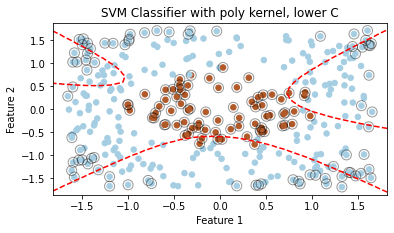

In [78]:
k= kernel_list[1]
clf = svm.SVC(kernel=k, C=0.1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel, lower C" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

#### **Variation of C using 'RBF' kernel** 

MEAN ACCURACY: 0.9641791044776119


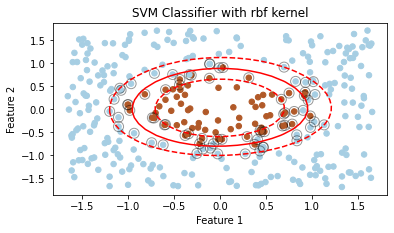

In [199]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.9462686567164179


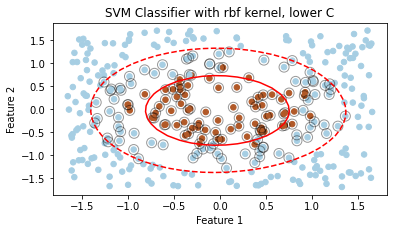

In [80]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=0.1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel, lower C" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

MEAN ACCURACY: 0.9671641791044776


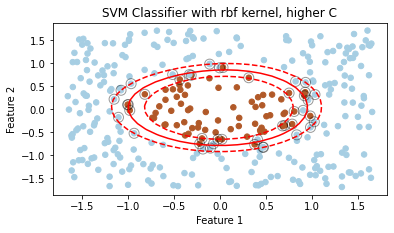

In [81]:
k= kernel_list[2]
clf = svm.SVC(kernel=k, C=5)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel, higher C" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

#### **'SIGMOID' kernel** 

MEAN ACCURACY: 0.6179104477611941


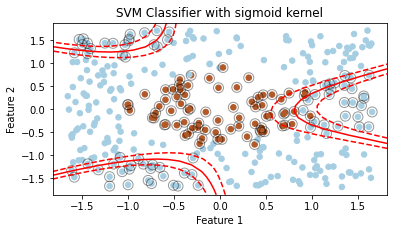

In [82]:
k= kernel_list[3]
clf = svm.SVC(kernel=k, C=1)
clf.fit(X3_train, y3_train)
plt.title("SVM Classifier with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_train, y3_train, clf)
a = clf.score(X3_train, y3_train)
print("MEAN ACCURACY:", a)

### **Testing generalisation on Datasets 1 and 2 using SVM Classifier**

In [83]:
test_data2 = np.genfromtxt("dataset_2_test.csv", delimiter=',')

test_data3 = np.genfromtxt("dataset_3_test.csv", delimiter=',')
print(test_data2[:5])
print(test_data3[:5])

[[ 1.65066304  1.48368445  1.        ]
 [-1.35823675 -0.45689923  0.        ]
 [ 1.50806978  1.61313444  1.        ]
 [ 0.77568203 -0.6483028   1.        ]
 [-1.26336035  0.3813452   0.        ]]
[[ 1.42964041  1.57345794  0.        ]
 [ 0.38857834  1.70428138  0.        ]
 [ 0.58905646 -0.48787516  1.        ]
 [ 1.2201303  -1.36146619  0.        ]
 [ 1.06502617  1.55921736  0.        ]]


In [84]:
X2_test = test_data2[:,0:2] #loading examples for dataset 2
y2_test= test_data2[:,2] #loading labels 
X3_test = test_data3[:,0:2] #loading examples for dataset 3
y3_test = test_data3[:,2] #loading labels 

#### **Record of chosen parameters, accuracies and time in Dataset 2**


Chosen parameters are **rbf kernel** and **C=3**, which yielded good enough mean accuracy with training data. At first I thought higher C, although improving performance in sample, was likely to cause overfitting. Now I've realised that higher C actually yields slightly better performance out of tample than C=1. Howevever I'd be more conservative with my choice of C, say C=1, in a real context.

MEAN ACCURACY: 0.7613293051359517
Running time: 0.06686663627624512


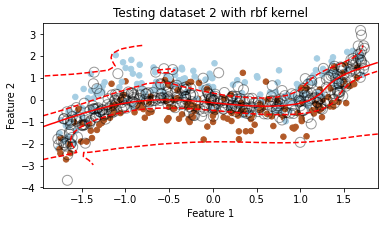

In [152]:
k= kernel_list[2]

start = time.time() #measuring time

clf1 = svm.SVC(kernel=k, C=3)
clf1.fit(X2_train, y2_train)
plt.title("Testing dataset 2 with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin(X2_test, y2_test, clf1)
a = clf1.score(X2_test, y2_test)
print("MEAN ACCURACY:", a)

end = time.time()
print("Running time:", end - start)

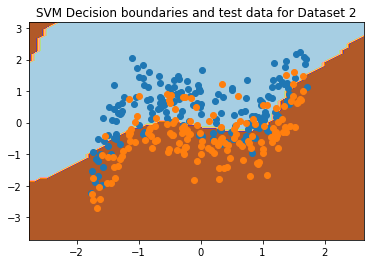

In [153]:
plt.title("SVM Decision boundaries and test data for Dataset 2")
plot_decisions(X2_test, y2_test, clf1)

#### **Record of chosen parameters, accuracies and time in Dataset 3**

For the third dataset I've chosen **rbf kernel** and **C=0.1**. Again, when training I believed C=1 would perform best out of sample, but when checking training data I've realised that C=0.1 improves performance. 

MEAN ACCURACY: 0.9818181818181818
Running time: 0.040538787841796875


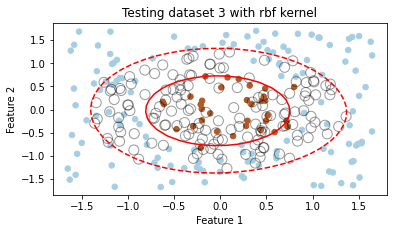

In [154]:
k= kernel_list[2]

start = time.time() #measuring time

clf2 = svm.SVC(kernel=k, C=0.1)
clf2.fit(X3_train, y3_train)
plt.title("Testing dataset 3 with %s kernel" % k )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plot_margin3(X3_test, y3_test, clf2)

a = clf2.score(X3_test, y3_test)

print("MEAN ACCURACY:", a)

end = time.time()
print("Running time:", end - start)

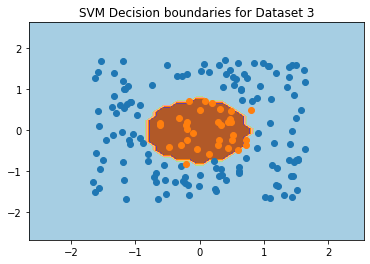

In [155]:
plt.title("SVM Decision boundaries for Dataset 3")
plot_decisions(X3_test, y3_test, clf2)

## **Neural Networks Approach: Exploration of performance of MLP Classifier for Datasets 2 and 3**

### **Exploration Dataset 2**

Parameters used were:
* solver=adam which refers to a stochastic gradient-based optimizer 
'sgd' performed worse, while adam and lbfgs achieved 0.76 and 0.75. **Adam performed better, and all took similar time**

* alpha=0.0001
which is the L2 regularization penalty term. **Larger values of alpha performed slighly worse.**

* activarion= relu **No activation function outperformed 'relu'**, but its worth pointing out that 'identity' activation was significantly quicker, which might make it preferable in different contexts.

In [180]:

start = time.time() #measuring time

clf3 = MLPClassifier(random_state=1, max_iter=300, solver='adam', activation='relu', alpha=0.0001).fit(X2_train, y2_train)

a= clf3.score(X2_test, y2_test)

print("\nMEAN ACCURACY:", a)
end = time.time()

print("\nRunning time:", end - start)



MEAN ACCURACY: 0.7673716012084593

Running time: 1.3917279243469238


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## **Record of accuracies and time in Dataset 2 using MLP Classifier**
#### **Variation of activation functions** using adam and default alpha
##### **identity activation**
MEAN ACCURACY: 0.7009063444108762

Running time: 0.25687479972839355
##### **logistic activation**

MEAN ACCURACY: 0.7069486404833837

Running time: 1.9627883434295654
##### **tanh activation**
MEAN ACCURACY: 0.7009063444108762

Running time: 1.1089248657226562

---

#### **Variation of alpha** using adam and relu activation

##### **alpha 0.01**

MEAN ACCURACY: 0.7673716012084593

Running time: 3.4824507236480713

#### **alpha 0.001**
MEAN ACCURACY: 0.7643504531722054

Running time: 1.4231369495391846

---

#### **Variation of solver** using alpha=0.0001 and relu activation

#### **ADAM, with alpha=0.0001 and relu activation** (best results)

MEAN ACCURACY: 0.7673716012084593

Running time: 1.377997875213623

#### **lbfgs**


MEAN ACCURACY: 0.7583081570996979

Running time: 1.9828081130981445

#### **sgd**


MEAN ACCURACY: 0.6888217522658611

Running time: 2.009523630142212

opt MEAN ACCURACY: 0.7673716012084593

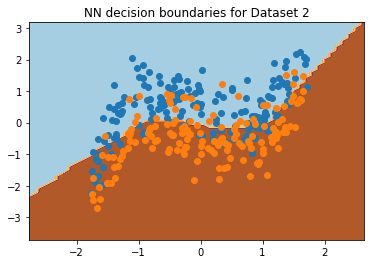

In [181]:
plt.title("NN decision boundaries for Dataset 2")
plot_decisions(X2_test, y2_test, clf3)

### **Exploration Dataset 3**

* Solver

'adam' was faster and achieved significantly better performance than the other solvers.
* Alpha regularisation

alpha=0.0001 since alpha did not improve performance with different values.
* activation function

'identity' and 'logistic' were faster than 'relu' activation, but relu outperformed and therefore it might be the best choice for this dataset.

In [198]:
start = time.time() #measuring time

clf4 = MLPClassifier(random_state=1, max_iter=300, solver='adam', activation='relu', alpha=0.01).fit(X3_train, y3_train)

a = clf4.score(X3_test, y3_test)

print("\n\nMEAN ACCURACY:", a)

end = time.time()

print("\nRunning time:", end - start)




MEAN ACCURACY: 0.9878787878787879

Running time: 2.8646957874298096


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### **Record of accuracies and time in Dataset 3 using MLP Classifier**


#### **Variation of activation function** using adam and alpha=0.0001


##### **identity activation**

MEAN ACCURACY: 0.8

Running time: 0.26758527755737305

##### **logistic activation**
MEAN ACCURACY: 0.8

Running time: 0.22579264640808105

##### **tanh activation**

MEAN ACCURACY: 0.8

Running time: 1.1204233169555664

---

#### **Variation of alpha** using adam and relu activation


##### **alpha 0.01**
MEAN ACCURACY: 0.9878787878787879

Running time: 2.8646957874298096

##### **alpha 0.001**
MEAN ACCURACY: 0.9878787878787879

Running time: 1.762267827987671

---

#### **Variation of solver** using alpha=0.0001 and relu activation


##### **ADAM, with alpha=0.0001 and relu activation** (best results)

MEAN ACCURACY: 0.9878787878787879

Running time: 0.7407526969909668

##### **lbfgs**
MEAN ACCURACY: 0.9575757575757575

Running time: 1.2219676971435547

##### **sgd**
MEAN ACCURACY: 0.8

Running time: 1.6519482135772705

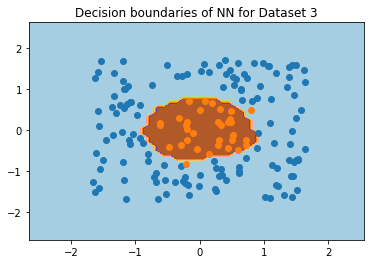

In [159]:
plt.title("Decision boundaries of NN for Dataset 3")
plot_decisions(X3_test, y3_test, clf4)

## Reflection


SVM can use kernels to perform complex non linear classification.

The support vector classificator used is sklearn’s SVC. This model has multiple parameters that can be tuned, most notably C, the main regularisation parameter already seen in Task 1. The other major parameter that will be explored is the kernel type to be used in the algorithm (existing types are ***‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’).***

IN SVMs, Kernels work by defining new features $f_1$ as a **measure of similarity between training examples and chosen landmarks**, where the similarity function is a mathematical kernel function. 

In the sk model we’re using, the rbf corresponds to a gaussian kernel.

### SVM Data Exploration

To optimise exploration, a list was created with all kernel types. All types have been tried. Last type, ‘precomputed’ was not included. 

An adapted version of the plot_margin function provided was used with different colours and opacities that made relevant data more visible in the plots.

First,  training examples from datasets 2 and 3 were explored varying parameters from the SVC model. Datasets 2 and 3 contain data which is not linearly separable, as seen in figures 5 and 6.

For dataset 2, 4 different kernels were tested.

Linear kernel resulted in a good 7.2 accuracy, but didn't achieve significant improvement on performance with other values of C, so only C=1 is recorded. 

Polynomial kernel did worse than linear for all 3 values of C tried, the best being the larger one C=5.

RFB kernel yielded the best performance, 0.77 accuracy with C=1, doing slightly better with a larger C=3.

Sigmoid kernel didn’t achieve significant performance with any value of C. Highest accuracy was 0.64

**Chosen SVM configuration for dataset 2 was rbf kernel with C=1.**

---

In dataset 3, best accuracy was 0.967 using rbf kernel with higher C=5, but it is decided to chose a more conservative C=1. Wider margins are again prefered as they’ll more likely generalise better.

The rest of kernels performed similarily here than they did with dataset 2.

Sigmoid kernel performed the worse with 0.61 accuracy and both linear and polynomial kernels performed better but not as well as rbf.

**Chosen SVM configuration for dataset 3 was rbf kernel with C=1.**

---

After training, generalisation was tested for both chosen models, after which, conlcusions were changed:

**Final parameters chosen best for dataset 2 are rbf kernel and C=3**, which yielded good enough mean accuracy with training data. At first it was thought that  higher C, would improve performance in sample, but would likely cause overfitting. After testing, it is observed that higher C actually yields slightly better performance out of tample than C=1. Howevever performance would probably be safer with a more conservative choice of C, say C=1, in a real context.

Further comment on how the obtained boundaries compare to NN in the last part of the reflection.

Similarily, **best parameters or dataset 3 are changed to rbf kernel and C=0.1.** Again, when training I believed C=1 would perform best out of sample, but when checking training data I've realised that C=0.1 improves performance. 

Running times for both models is relativelty quick, around 0.06 and 0.04 seconds.

## NN Approach

## Exploration of dataset 2

When using MLPClassifier, best performings parameters were adam as solver (SGD with adam optimiser), alpha=0.0001 and relu as activation function. Activation function ‘identity’ performed worse than relu but was significantly quicker, which might make it preferable in different contexts.

Best accuracy, as described, was 0.7673716012084593.

Detailed record of lower accuracies achieved by switching parameters is included in the code.

## Exploration of dataset 3

Performance achieved by SVM was 0.9818.

Identiy and logistic activations functions were much faster than relu but relu outperformed all. 

Adam was faster  and achieved significantly better performance than the other solvers.

Alpha regularisation was set to 0.0001 since alpha did not improve performance with different values.

Detailed record of lower accuracies achieved by switching parameters is included in the code.

**Comparison between SVM and NN for dataset 2**

The decision boundary plotted by this method isn’t as smooth as the one we’ll obtain through NN. It can be seen in the SVM Decision boundary plot that the top left hand corner contains a bit of area belonging to the bottom class, which could be a sign of overfitting.

Performance of SVM for dataset 2 is 0.7613, in opposition to NN’s best performance which yielded a similar 0.7673.

Running time for SVM is 0.066s versus NN’s which took 1.39s

**Comparison between SVM and NN for dataset 3.** 

The decision boundary created by SVM for is uneven and more irregular, compared to the one obtained by NN. This is a sign of overfitting and leads me to preffer the NN approach.

Performance achieved by SVM was 0.9818, and NN got to an only slighlty better 0.9878. Timewise, NN took a running time of 1.76s in comparison to SVMs which achieved a very similar accuracy in the much shorter time of 0.040s.